<a href="https://colab.research.google.com/github/MedvedevIvanV/Code_example/blob/master/act(30_10_2024).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, max_error, mean_absolute_percentage_error, mean_absolute_error
from scipy import integrate
from scipy.optimize import curve_fit

In [2]:
pip install gdown==v4.6.0

  Attempting uninstall: gdown
    Found existing installation: gdown 5.2.0
    Uninstalling gdown-5.2.0:
      Successfully uninstalled gdown-5.2.0


In [3]:
!pip install --upgrade gdown

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.0
    Uninstalling gdown-4.6.0:
      Successfully uninstalled gdown-4.6.0


In [4]:
! gdown --id 1sx0gy0Ku4yW__4lVbXBhPJ5HwORHL2_E

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1sx0gy0Ku4yW__4lVbXBhPJ5HwORHL2_E
To: /content/actual_data.xlsx
100% 244k/244k [00:00<00:00, 34.3MB/s]


In [5]:
df = pd.read_excel('actual_data.xlsx')
second = np.array(df['min'])*60
df['hours'] = df['min']/60
REAL = np.array(df.iloc[1511, 2:59]).transpose()
df.head()

,min,day,A0('11-25'),A0('9-16' ),A0('9-10'),A0('9-20'),A0('9-24'),A0('9-27'),A0('9-11'),A0('11-28'),...,C('11-20'),C('11-04'),C(11-06'),C('10-28'),C('10-21'),C('11-13'),C('10-24'),C('10-30'),Surname,hours
0,0.0,0.000000,0.0073,0.0000,0.0061,0.0032,0.0107,0.0136,0.0142,0.0061,...,0.0038,0.0014,0.0013,0.0015,0.0008,0.0047,0.0009,0.0075,s1,0.000000
1,5.0,0.003472,0.0394,0.0709,0.0035,0.0029,0.0432,0.0332,0.0124,0.0021,...,0.0073,0.0019,0.0040,0.0008,0.0004,0.0091,0.0008,0.0046,s2,0.083333
2,10.0,0.006944,0.0744,0.1349,0.0092,0.0099,0.0819,0.0513,0.0044,0.0036,...,0.0161,0.0036,0.0094,0.0014,0.0006,0.0221,0.0014,0.0025,s3,0.166667
3,15.0,0.010417,0.0727,0.1605,0.0179,0.0243,0.1011,0.0599,0.0044,0.0075,...,0.0284,0.0071,0.0176,0.0024,0.0008,0.0383,0.0024,0.0064,s4,0.250000
4,20.0,0.013889,0.0685,0.1656,0.0416,0.0458,0.1104,0.0649,0.0047,0.0133,...,0.0434,0.0125,0.0279,0.0038,0.0011,0.0562,0.0039,0.0126,s5,0.333333


In [6]:
# Linear BOI and Q
def A_0(Q):
  x = (Q + 39.478)/9.862
  return x

def A_1(Q):
  x = (Q + 16.548)/7.9411
  return x

def B_0(Q):
  x = (Q + 41.036)/9.9758
  return x

def B_1(Q):
  x = (Q + 10.56)/7.9659
  return x

def C_0(Q):
  x = (Q + 30.168)/8.7912
  return x

def C_1(Q):
  x = (Q + 18.662)/7.3071
  return x


def renorm(New, Max, Min):
  return New*(Max-Min)+Min

def Renormalize(New, Max, Min):
  NewN = pd.DataFrame()
  for i in range(0, New.shape[1]-1):
    NewN[New.columns[i+1]] = renorm(New.iloc[:, i+1], Max[i], Min[i])
  return NewN

def normal(X):
  if X[25:].min() < 0.02:
    return (X-X[25:].min())/(X.max()-X[25:].min())
  else:
    return (X-0.02)/(X.max()-0.02)

def Normalize_time(k):
  Data = pd.DataFrame()
  for i in range(2, 59):
    Data[df.columns[i]] = normal(df.iloc[1:k, i])
  Max = []
  for i in range(2, 59):
    Max.append(df.iloc[1:k, i].max())
  Min = []
  for i in range(2, 59):
    if df.iloc[25:k, i].min() < 0.02:
      Min.append(df.iloc[25:k, i].min())
    else:
      Min.append(0.02)
  return (Data, Max, Min)

def left_rect(x, f):
  Q=[]
  SUM_Q = 0
  h = x[1]-x[0]
  for i in range(0, f.shape[0]):
    SUM_Q+=h*f[i]
    Q.append(SUM_Q)
  return Q

def BOI(Q_r, k=1):
  BOIA0 = [A_0(Q_r.T.values[i][:np.count_nonzero(~np.isnan(Q_r.T.values[i]))][-1]) for i in range(0, 9)]
  BOIB0 = [B_0(Q_r.T.values[i][:np.count_nonzero(~np.isnan(Q_r.T.values[i]))][-1]) for i in range(9, 18)]
  BOIC0 = [C_0(Q_r.T.values[i][:np.count_nonzero(~np.isnan(Q_r.T.values[i]))][-1]) for i in range(18, 27)]
  BOIA1 = [A_1(Q_r.T.values[i][:np.count_nonzero(~np.isnan(Q_r.T.values[i]))][-1]) for i in range(27, 37)]
  BOIB1 = [B_1(Q_r.T.values[i][:np.count_nonzero(~np.isnan(Q_r.T.values[i]))][-1]) for i in range(37, 47)]
  BOIC1 = [C_1(Q_r.T.values[i][:np.count_nonzero(~np.isnan(Q_r.T.values[i]))][-1]) for i in range(47, 57)]
  return BOIA0 + BOIB0 + BOIC0 + BOIA1 + BOIB1 + BOIC1

def MAPE(boi):
  MAPE_PRED = []
  for i in range(0, 57):
    MAPE_PRED.append(mean_absolute_percentage_error([REAL[i]], [boi[i]]))
  return MAPE_PRED

In [7]:
def QQQ(s, _Data):
  Data = pd.DataFrame()
  Data['long'] = pd.Series([i for i in range(1511)])
  for i in range(_Data.shape[1]):
    Q = left_rect(s, _Data.iloc[:, i].values[:np.count_nonzero(~np.isnan(_Data.iloc[:, i].values))]/100)
    Data[_Data.columns[i]] = Q + [None] * (1511 - len(Q))

  Data.drop('long', axis=1, inplace=True)
  return Data

In [8]:
def new_Normalize_time(k, _Data):
  Data = pd.DataFrame()
  Data['long'] = pd.Series([i for i in range(1511)])
  for i in range(_Data.shape[1]):
    Data[_Data.columns[i]] = normal(_Data.iloc[1:k[i], i])

  Max = []
  Min = []

  for i in range(_Data.shape[1]):
    Max.append(_Data.iloc[1:k[i], i].max())
    if _Data.iloc[25:k[i], i].min() < 0.02:
      Min.append(_Data.iloc[25:k[i], i].min())
    else:
      Min.append(0.02)
  Data.drop('long', axis=1, inplace=True)
  Data.drop(Data.index[0], axis=0, inplace=True)

  return (Data, Max, Min)

In [9]:
B = df.iloc[:-1, 2:59]
indexes = B.fillna(0).apply(lambda x: x.loc[x.idxmax():][x <= x.max() / 1.75].idxmax()).tolist()
indexes = np.array(indexes)
indexes= np.where(indexes > 289, 289, indexes)
indexes= np.where(indexes < 49, 49, indexes)

In [17]:
B = B.drop(B.columns[[8, 17, 26]], axis=1)

In [27]:
# Функция для вычисления индексов
def find_indices_multiple_columns(db, initial_points=12, total_points=289):
    results = {}

    for column in db.columns:
        current_index = 12
        indices = []
        initial_points=12
        total_points=289

        while (current_index < len(db)) and (len(indices) < total_points):
            end_index = current_index + initial_points

            if end_index > len(db):
                break

            points = db[column][current_index:end_index]

            # Вычисляем производную (разность)
            derivative = np.diff(points)

            # Находим среднее значение производной
            mean_derivative = np.mean(derivative)

            # Проверка знака производной
            if mean_derivative < 0:
                MR = (end_index + current_index)/2
                indices.append(end_index)  # Добавляем текущий индекс
                break  # Если отрицательное, выходим из цикла
            else:
                # Если положительное, увеличиваем количество точек
                # initial_points += 24  # Увеличиваем количество точек на 24
                current_index += 4  # Переходим к следующей части

            if initial_points > 260:
                indices.append(144)
                break
        if not indices:
            indices.append(144)
        results[column] = indices  # Сохраняем результаты для каждого столбца

    return results

# Получаем индексы для всех столбцов
result_indices = find_indices_multiple_columns(B.iloc[:289, :])
print("Индексы, где средняя производная отрицательная для каждого столбца:")
for col, indices in result_indices.items():
    print(f"{col}: {indices}")

Индексы, где средняя производная отрицательная для каждого столбца:
A0('11-25'): [24]
A0('9-16' ): [24]
A0('9-10'): [24]
A0('9-20'): [24]
A0('9-24'): [24]
A0('9-27'): [52]
A0('9-11'): [160]
A0('11-28'): [216]
B0('11-25'): [24]
B0('9-16'): [24]
B0('9-10'): [24]
B0('9-20'): [24]
B0(9-24'): [24]
B0('9-27'): [32]
B0('9-11'): [184]
B0('11-28'): [192]
C0('11-25'): [24]
C0('9-16'): [24]
C0('9-10'): [24]
C0('9-20'): [24]
C0('9-24'): [24]
C0('9-27'): [48]
C0('9-11'): [152]
C0('11-28'): [256]
A('11-12'): [32]
A('11-11'): [36]
A('11-20'): [44]
A('11-04'): [44]
A(11-06'): [60]
A('10-28'): [56]
A('10-21'): [92]
A('11-13'): [96]
A('10-24'): [140]
A('10-30'): [164]
B('11-12'): [28]
B('11-11'): [32]
B('11-20'): [32]
B('11-04'): [40]
B(11-06'): [60]
B('10-28'): [60]
B('10-21'): [108]
B('11-13'): [96]
B('10-24'): [148]
B('10-30'): [164]
C('11-12'): [32]
C('11-11'): [36]
C('11-20'): [36]
C('11-04'): [40]
C(11-06'): [52]
C('10-28'): [56]
C('10-21'): [108]
C('11-13'): [60]
C('10-24'): [128]
C('10-30'): [13

In [28]:
idp = np.array([])
for j in range(len(list(result_indices.values()))):
    idp = np.append(idp, list(result_indices.values())[j][0])

In [29]:
idp = idp.astype(int)
idp

array([ 24,  24,  24,  24,  24,  52, 160, 216,  24,  24,  24,  24,  24,
        32, 184, 192,  24,  24,  24,  24,  24,  48, 152, 256,  32,  36,
        44,  44,  60,  56,  92,  96, 140, 164,  28,  32,  32,  40,  60,
        60, 108,  96, 148, 164,  32,  36,  36,  40,  52,  56, 108,  60,
       128, 136])

In [30]:
maxes = np.array([B.iloc[:idp[i], i].idxmax() for i in range(B.shape[1])])

In [22]:
maxes

array([  2,   4,   5,   7,   7,  41, 148, 209,   2,   6,   6,   6,   7,
        21,   0, 180,  13,  16,   4,   6,   7,  23,  23,  47,  23,  25,
        35,  31,  35,  43,  43,  59,  55,  90,  20,  24,  23,  27,  31,
        31,  39,  59,  59, 107,  21,  27,  26,  31,  35,  35,  39,  45,
        55, 106])

In [ ]:
i = 6

In [ ]:
B.iloc[:maxes[i], i][B.iloc[:maxes[i], i] >= B.iloc[maxes[i], i] * 0.9]

100    0.0192
101    0.0193
102    0.0193
103    0.0194
104    0.0194
105    0.0195
106    0.0196
107    0.0195
108    0.0196
109    0.0198
110    0.0198
111    0.0199
112    0.0199
113    0.0200
114    0.0200
115    0.0201
116    0.0202
117    0.0202
118    0.0202
119    0.0203
120    0.0204
121    0.0204
122    0.0204
123    0.0204
124    0.0204
125    0.0204
126    0.0205
127    0.0206
128    0.0206
129    0.0207
130    0.0207
131    0.0208
132    0.0209
133    0.0209
134    0.0209
135    0.0209
136    0.0209
137    0.0210
138    0.0210
139    0.0210
140    0.0211
141    0.0210
142    0.0211
143    0.0211
144    0.0211
145    0.0212
146    0.0212
147    0.0212
Name: A0('9-11'), dtype: float64

NameError: name 'i' is not defined

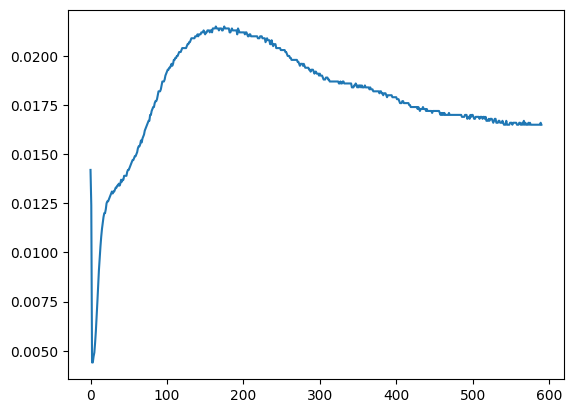

In [23]:
plt.plot(B.iloc[:, 6])
plt.vlines(maxes[i], 0, B.iloc[maxes[i], 6])

In [ ]:
B.iloc[maxes[i]:, i][B.iloc[maxes[i]:, i] <= B.iloc[maxes[i], i] * 0.9].index[0]

293

In [25]:
LEN = B.shape[1]

In [31]:
right_bound = np.zeros((9, LEN))
left_bound = np.zeros((9, LEN))
r_values = [0.9, 0.8, 0.75, 0.7, 0.6, 0.55, 0.5, 0.45, 0.4]
l_values = [0.9, 0.8, 0.75, 0.7, 0.6, 0.55, 0.5, 0.45, 0.4]

for j, k in enumerate(r_values):
    for i in range(LEN):
        filtered_indices = B.iloc[maxes[i]:, i][B.iloc[maxes[i]:, i] <= B.iloc[maxes[i], i] * k]

        if not filtered_indices.empty:
            right_bound[j, i] = filtered_indices.index[0]
        else:
            right_bound[j, i] = B.iloc[maxes[i]:, i].idxmin()

for j, k in enumerate(l_values):
    for i in range(LEN):
        filtered_indices = B.iloc[:maxes[i], i][B.iloc[:maxes[i], i] >= B.iloc[maxes[i], i] * k]

        if not filtered_indices.empty:
            left_bound[j, i] = filtered_indices.index[0]
        else:
            left_bound[j, i] = B.iloc[:maxes[i], i].idxmin()

In [32]:
def new_Normalize_time(k, _Data):
  Data = pd.DataFrame()
  Data['long'] = pd.Series([i for i in range(1511)])
  for i in range(_Data.shape[1]):
    Data[_Data.columns[i]] = normal(_Data.iloc[1:k[i], i])

  Max = []
  Min = []

  for i in range(_Data.shape[1]):
    Max.append(_Data.iloc[maxes[i], i])
    if _Data.iloc[25:k[i], i].min() < 0.02:
      Min.append(_Data.iloc[25:k[i], i].min())
    else:
      Min.append(0.02)
  Data.drop('long', axis=1, inplace=True)
  Data.drop(Data.index[0], axis=0, inplace=True)

  return (Data, Max, Min)

In [33]:
def f2(x, sigma, mu, a, b):
  return (np.exp(-((np.log(x) - mu)**2) / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi))) - a/(b + x**2)

def mnk2(T, date, param, lst1, lst2):
    try:
        popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
        return popt
    except Exception as e:
        print(f"Ошибка при выполнении curve_fit: {e}. Используем параметры по умолчанию.")
        return (1.5, 0.5, 0.1, 0.5)

def new_Method(Data, k, s, cluster):
  New = pd.DataFrame()
  coeff = pd.DataFrame()
  New['long'] = df.iloc[1:-1, 1]
  for i in range(0, Data.shape[1]):
    if cluster==1:
      param = (1.5, 0.5, 0.1, 0.5)
      lst1, lst2 = [0, -1.5, -1.5, 0.05], [1.9, 0.55, 0.15, 1.2]
    else:
      param = (1.5, 0.5, -0.1, 1)
      lst1, lst2 = [0, -0.3, -1, 0.8], [4, 3.5, 0.3, 1.2]
    sigma, mu, a, b = mnk2(Data.iloc[s[i]:Data.iloc[:k[i], i].count(), i], df.iloc[s[i]+1:Data.iloc[:k[i], i].count()+1, 1], param, lst1, lst2)
    coeff[Data.columns[i]] = sigma, mu, a, b
    New[Data.columns[i]] = f2(df.iloc[1:1300, 1], sigma, mu, a, b)
  return New, coeff

In [34]:
right_bound = right_bound.astype(int)
left_bound =  left_bound.astype(int)

In [37]:
def f2(x, sigma, mu, a, b):
  return (np.exp(-((np.log(x) - mu)**2) / (2 * sigma**2)) / (x * sigma * np.sqrt(2 * np.pi))) - a/(b + x**2)

def mnk2(T, date, param, lst1, lst2):
    try:
        popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
        return popt
    except Exception as e:
        print(f"Ошибка при выполнении curve_fit: {e}. Используем параметры по умолчанию.")
        return (1.5, 0.5, 0.1, 0.5)

def new_Method(Data, k, s, cluster):
  New = pd.DataFrame()
  coeff = pd.DataFrame()
  New['long'] = df.iloc[1:-1, 1]
  for i in range(0, Data.shape[1]):
    if cluster==1:
      param = (1.5, 0.5, 0.1, 0.5)
      lst1, lst2 = [0, -1.5, -1.5, 0.05], [1.9, 0.55, 0.15, 1.2]
    else:
      param = (1.5, 0.5, -0.1, 1)
      lst1, lst2 = [0, -0.3, -1, 0.8], [4, 3.5, 0.3, 1.2]
    sigma, mu, a, b = mnk2(Data.iloc[s[i]:Data.iloc[:k[i], i].count(), i], df.iloc[s[i]+1:Data.iloc[:k[i], i].count()+1, 1], param, lst1, lst2)
    coeff[Data.columns[i]] = sigma, mu, a, b
    New[Data.columns[i]] = f2(df.iloc[1:1300, 1], sigma, mu, a, b)
  return New, coeff

In [41]:
B1 = B.iloc[:, :24]
B2 = B.iloc[:, 24:]

In [45]:
Q_realAll.ffill().iloc[-1]

,1510
A0('11-25'),126.028500
A0('9-16' ),134.989500
A0('9-10'),22.257589
A0('9-20'),89.625600
A0('9-24'),101.048700
A0('9-27'),161.875011
A0('9-11'),31.789500
A0('11-28'),117.677700
B0('11-25'),113.661600
B0('9-16'),130.546500


In [46]:
results1 = []

for I in range(right_bound.shape[0]):
    Data_new, Max_new, Min_new = new_Normalize_time(right_bound[I, :], B1)
    for J in range(left_bound.shape[0]):
        New_new, coeff_new = new_Method(Data_new, right_bound[I, :], left_bound[J, :], 0)

        NewN_new = Renormalize(New_new, Max_new, Min_new)
        NewN_new[NewN_new < 0] = 0

        Ad = pd.DataFrame()
        Ad['long'] = pd.Series([i for i in range(1511)])
        for i in range(B1.shape[1]):
            Ad[df.columns[i+2]] = [NewN_new.iloc[:B1.iloc[:, i].count(), i] for i in range(B1.shape[1])][i]
        Ad.drop('long', axis=1, inplace=True)
        Ad.drop(Ad.index[0], axis=0, inplace=True)


        Q_pred = QQQ(second[1:-1], Ad)
        Q_real = QQQ(second[:-1], B1)

        pred_Q = np.array([mean_absolute_percentage_error([Q_real.ffill().iloc[-1, i]], [Q_pred.ffill().iloc[-1, i]]) for i in range(B1.shape[1])])

        r2 = r2_score(Q_real.ffill().iloc[-1], Q_pred.ffill().iloc[-1])
        max_err = max_error(Q_real.ffill().iloc[-1], Q_pred.ffill().iloc[-1])
        mae = mean_absolute_error(Q_real.ffill().iloc[-1], Q_pred.ffill().iloc[-1])

        # boi_all_real = BOI(Q_realAll)
        # boi = BOI(Q_real, k=1)


        # # pred = np.round(np.array(MAPE(boi))*100, 3)
        # # real_mape = np.round(np.array(MAPE(boi_all_real))*100, 3)

        # pred_Q = np.array([mean_absolute_percentage_error([boi_all_real[i]], [boi[i]]) for i in range(57)])

        # r2 = r2_score(boi_all_real, boi)
        # max_err = max_error(boi_all_real, boi)
        # mae = mean_absolute_error(boi_all_real, boi)

        # print(real_mape.mean())
        # print('newsssss ', pred.mean())
        print("R^2 score:", r2)
        print("Максимальная абсолютная ошибка:", max_err)
        print("Средняя абсолютная ошибка:", mae)
        # print("Максимальная процентная ошибка:", pred.max())

        results1.append({
            'I': I,
            'J': J,
            'coeff_new': coeff_new.to_dict(orient='records'),  # Преобразуем в список для хранения
            #'real_mape_mean': real_mape.mean(),
            #'pred_mean': pred.mean(),
            'R2_score': r2,
            'max_error': max_err,
            'mae': mae,
            #'max_percentage_error': pred.max(),
            'pred_Q': pred_Q.mean(),
            'pred_Qmax': pred_Q.max(),
        })

<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


Ошибка при выполнении curve_fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.. Используем параметры по умолчанию.


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.7990380858599488
Максимальная абсолютная ошибка: 42.35293028046878
Средняя абсолютная ошибка: 13.185063520643267


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


Ошибка при выполнении curve_fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.. Используем параметры по умолчанию.


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8086685990314852
Максимальная абсолютная ошибка: 41.87625968290223
Средняя абсолютная ошибка: 12.62600035602175


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


Ошибка при выполнении curve_fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.. Используем параметры по умолчанию.


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8134876026663693
Максимальная абсолютная ошибка: 41.87625968290223
Средняя абсолютная ошибка: 12.529352689680076


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


Ошибка при выполнении curve_fit: Optimal parameters not found: The maximum number of function evaluations is exceeded.. Используем параметры по умолчанию.


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8143654208756042
Максимальная абсолютная ошибка: 41.254842879069415
Средняя абсолютная ошибка: 12.846143577002488


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8108830602631139
Максимальная абсолютная ошибка: 41.254842879069415
Средняя абсолютная ошибка: 13.337997053196295


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8255987486239392
Максимальная абсолютная ошибка: 41.254842879069415
Средняя абсолютная ошибка: 12.71357164447717


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.7821999477138095
Максимальная абсолютная ошибка: 47.980558654504335
Средняя абсолютная ошибка: 13.915151645037056


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.7823719320891368
Максимальная абсолютная ошибка: 47.980558654504335
Средняя абсолютная ошибка: 13.868833249457412


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.7889852423000477
Максимальная абсолютная ошибка: 47.980558654504335
Средняя абсолютная ошибка: 13.749290252131127


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8578001270737144
Максимальная абсолютная ошибка: 43.00097829511233
Средняя абсолютная ошибка: 11.70600293917642


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8547355361334311
Максимальная абсолютная ошибка: 42.62855224304387
Средняя абсолютная ошибка: 11.528070271421436


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8580064218707462
Максимальная абсолютная ошибка: 42.62855224304387
Средняя абсолютная ошибка: 11.544865937743026


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8611433770849842
Максимальная абсолютная ошибка: 42.126397984037965
Средняя абсолютная ошибка: 11.184070093992494


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8192687560123284
Максимальная абсолютная ошибка: 52.35280351595439
Средняя абсолютная ошибка: 12.031713682750228


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8186832369703487
Максимальная абсолютная ошибка: 52.35280351595439
Средняя абсолютная ошибка: 12.057146281024385


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8371408980393713
Максимальная абсолютная ошибка: 52.35280351595439
Средняя абсолютная ошибка: 11.009120550771359


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8373405708324938
Максимальная абсолютная ошибка: 52.35280351595439
Средняя абсолютная ошибка: 10.97134938811967


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8124812998484021
Максимальная абсолютная ошибка: 52.35280351595439
Средняя абсолютная ошибка: 11.88914753856003


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8263111969698792
Максимальная абсолютная ошибка: 43.113312713844564
Средняя абсолютная ошибка: 12.677952793403025


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8355437066245603
Максимальная абсолютная ошибка: 42.79178339475756
Средняя абсолютная ошибка: 12.050034375773706


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8384991810689818
Максимальная абсолютная ошибка: 42.79178339475756
Средняя абсолютная ошибка: 11.949063352843618


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8411254913732232
Максимальная абсолютная ошибка: 42.345779008252606
Средняя абсолютная ошибка: 11.66328251150251


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8035667880524305
Максимальная абсолютная ошибка: 53.842995453759045
Средняя абсолютная ошибка: 12.317348990882545


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.7975980536052194
Максимальная абсолютная ошибка: 53.842995453759045
Средняя абсолютная ошибка: 12.615703798222102


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8058464171870809
Максимальная абсолютная ошибка: 53.842995453759045
Средняя абсолютная ошибка: 12.066141988927045


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8060392108703094
Максимальная абсолютная ошибка: 53.842995453759045
Средняя абсолютная ошибка: 12.03104854886292


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.7979159051128882
Максимальная абсолютная ошибка: 53.842995453759045
Средняя абсолютная ошибка: 12.778950262527053


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8302143591909176
Максимальная абсолютная ошибка: 43.13883044164312
Средняя абсолютная ошибка: 11.969575990673158


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8320356430911505
Максимальная абсолютная ошибка: 42.877965204721306
Средняя абсолютная ошибка: 11.645918611592537


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8343525820437276
Максимальная абсолютная ошибка: 42.877965204721306
Средняя абсолютная ошибка: 11.464118521038875


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.8362713963476277
Максимальная абсолютная ошибка: 42.49955700645326
Средняя абсолютная ошибка: 11.269051348265315


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.803439919150027
Максимальная абсолютная ошибка: 53.952094048821905
Средняя абсолютная ошибка: 11.786475616045655


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.7952722219504155
Максимальная абсолютная ошибка: 53.952094048821905
Средняя абсолютная ошибка: 12.200622364841024


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.7986833671261973
Максимальная абсолютная ошибка: 53.952094048821905
Средняя абсолютная ошибка: 11.9873320279643


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.7988622891197833
Максимальная абсолютная ошибка: 53.952094048821905
Средняя абсолютная ошибка: 11.954753923602398


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.7989078051065384
Максимальная абсолютная ошибка: 53.952094048821905
Средняя абсолютная ошибка: 12.269875912740117
R^2 score: 0.8781479245036039
Максимальная абсолютная ошибка: 42.85041967262363
Средняя абсолютная ошибка: 9.607567538472304
R^2 score: 0.8738854934432215
Максимальная абсолютная ошибка: 42.85041967262363
Средняя абсолютная ошибка: 9.733582656084254
R^2 score: 0.8687427098505577
Максимальная абсолютная ошибка: 42.85041967262363
Средняя абсолютная ошибка: 9.920530458919137
R^2 score: 0.8626513445944863
Максимальная абсолютная ошибка: 42.85041967262363
Средняя абсолютная ошибка: 10.034049434562258
R^2 score: 0.8965093949930591
Максимальная абсолютная ошибка: 41.72586716358727
Средняя абсолютная ошибка: 9.07813134400994
R^2 score: 0.8947164014959548
Максимальная абсолютная ошибка: 41.72586716358727
Средняя абсолютная ошибка: 9.175606985469651
R^2 score: 0.8945483302244805
Максимальная абсолютная ошибка: 41.72586716358727
Средняя абсолютная ошибка: 9.18030042736790

In [61]:
B2

,A('11-12'),A('11-11'),A('11-20'),A('11-04'),A(11-06'),A('10-28'),A('10-21'),A('11-13'),A('10-24'),A('10-30'),...,C('11-12'),C('11-11'),C('11-20'),C('11-04'),C(11-06'),C('10-28'),C('10-21'),C('11-13'),C('10-24'),C('10-30')
0,0.0044,0.0016,0.0000,0.0018,0.0003,0.0017,0.0017,0.0044,0.0019,0.0104,...,0.0020,0.0013,0.0038,0.0014,0.0013,0.0015,0.0008,0.0047,0.0009,0.0075
1,0.0006,0.0008,0.0002,0.0008,0.0006,0.0006,0.0009,0.0023,0.0010,0.0025,...,0.0007,0.0011,0.0073,0.0019,0.0040,0.0008,0.0004,0.0091,0.0008,0.0046
2,0.0007,0.0024,0.0562,0.0016,0.0014,0.0010,0.0012,0.0083,0.0018,0.0032,...,0.0012,0.0027,0.0161,0.0036,0.0094,0.0014,0.0006,0.0221,0.0014,0.0025
3,0.0011,0.0039,0.0577,0.0030,0.0030,0.0020,0.0014,0.0208,0.0034,0.0087,...,0.0021,0.0050,0.0284,0.0071,0.0176,0.0024,0.0008,0.0383,0.0024,0.0064
4,0.0017,0.0059,0.0659,0.0056,0.0053,0.0028,0.0017,0.0394,0.0060,0.0162,...,0.0036,0.0078,0.0434,0.0125,0.0279,0.0038,0.0011,0.0562,0.0039,0.0126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1507,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


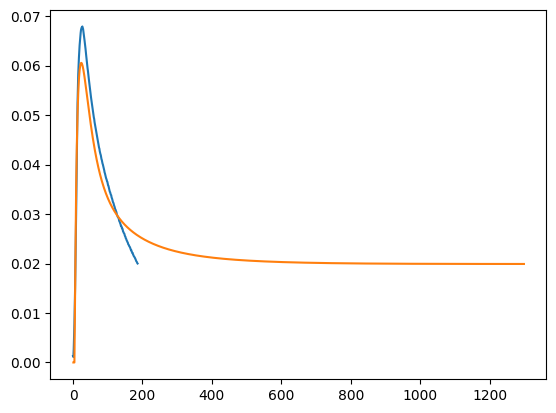

In [65]:
plt.plot(B2.iloc[:, 21])
plt.plot(NewN_new.iloc[:, 21])

In [58]:
results2 = []

for I in range(right_bound.shape[0]):
    Data_new, Max_new, Min_new = new_Normalize_time(right_bound[I, :], B2)
    for J in range(left_bound.shape[0]):
        New_new, coeff_new = new_Method(Data_new, right_bound[I, :], left_bound[J, :], 1)

        NewN_new = Renormalize(New_new, Max_new, Min_new)
        NewN_new[NewN_new < 0] = 0

        Ad = pd.DataFrame()
        Ad['long'] = pd.Series([i for i in range(1511)])
        for i in range(B2.shape[1]):
            Ad[df.columns[i+2]] = [NewN_new.iloc[:B2.iloc[:, i].count(), i] for i in range(B2.shape[1])][i]
        Ad.drop('long', axis=1, inplace=True)
        Ad.drop(Ad.index[0], axis=0, inplace=True)


        Q_pred = QQQ(second[1:-1], Ad)
        Q_real = QQQ(second[:-1], B2)

        pred_Q = np.array([mean_absolute_percentage_error([Q_real.ffill().iloc[-1, i]], [Q_pred.ffill().iloc[-1, i]]) for i in range(B2.shape[1])])

        r2 = r2_score(Q_real.ffill().iloc[-1], Q_pred.ffill().iloc[-1])
        max_err = max_error(Q_real.ffill().iloc[-1], Q_pred.ffill().iloc[-1])
        mae = mean_absolute_error(Q_real.ffill().iloc[-1], Q_pred.ffill().iloc[-1])

        # boi_all_real = BOI(Q_realAll)
        # boi = BOI(Q_real, k=1)


        # # pred = np.round(np.array(MAPE(boi))*100, 3)
        # # real_mape = np.round(np.array(MAPE(boi_all_real))*100, 3)

        # pred_Q = np.array([mean_absolute_percentage_error([boi_all_real[i]], [boi[i]]) for i in range(57)])

        # r2 = r2_score(boi_all_real, boi)
        # max_err = max_error(boi_all_real, boi)
        # mae = mean_absolute_error(boi_all_real, boi)

        # print(real_mape.mean())
        # print('newsssss ', pred.mean())
        print("R^2 score:", r2)
        print("Максимальная абсолютная ошибка:", max_err)
        print("Средняя абсолютная ошибка:", mae)
        # print("Максимальная процентная ошибка:", pred.max())

        results2.append({
            'I': I,
            'J': J,
            'coeff_new': coeff_new.to_dict(orient='records'),  # Преобразуем в список для хранения
            #'real_mape_mean': real_mape.mean(),
            #'pred_mean': pred.mean(),
            'R2_score': r2,
            'max_error': max_err,
            'mae': mae,
            #'max_percentage_error': pred.max(),
            'pred_Q': pred_Q.mean(),
            'pred_Qmax': pred_Q.max(),
        })

<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.26038496005566547
Максимальная абсолютная ошибка: 293.1850668355243
Средняя абсолютная ошибка: 51.369085810826235


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.24885000247617972
Максимальная абсолютная ошибка: 292.1169454461961
Средняя абсолютная ошибка: 52.31984181797345


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.2440593181201628
Максимальная абсолютная ошибка: 292.1169454461961
Средняя абсолютная ошибка: 52.66764596074225


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.24044757057082522
Максимальная абсолютная ошибка: 292.1169454461961
Средняя абсолютная ошибка: 52.771985397744764


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.23432804114170702
Максимальная абсолютная ошибка: 292.1169454461961
Средняя абсолютная ошибка: 53.55896164294718


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.23388138523603064
Максимальная абсолютная ошибка: 291.3982028988867
Средняя абсолютная ошибка: 53.71570174663356


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.23238053800023462
Максимальная абсолютная ошибка: 291.3982028988867
Средняя абсолютная ошибка: 53.62131176567893


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.23065976810137756
Максимальная абсолютная ошибка: 291.3982028988867
Средняя абсолютная ошибка: 53.81427253204109


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.22852622647151488
Максимальная абсолютная ошибка: 291.3982028988867
Средняя абсолютная ошибка: 54.20022061866868


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.27818146672798194
Максимальная абсолютная ошибка: 287.8708679557247
Средняя абсолютная ошибка: 50.577087610170125


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.2649461352804948
Максимальная абсолютная ошибка: 286.9395615462657
Средняя абсолютная ошибка: 51.57303314609499


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.26159672455211636
Максимальная абсолютная ошибка: 286.9395615462657
Средняя абсолютная ошибка: 51.920527618963284


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.25744643794151345
Максимальная абсолютная ошибка: 286.9395615462657
Средняя абсолютная ошибка: 52.38941593614901


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.2426025202150789
Максимальная абсолютная ошибка: 286.9395615462657
Средняя абсолютная ошибка: 52.74734877454389


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.23926490918686838
Максимальная абсолютная ошибка: 287.3741950238234
Средняя абсолютная ошибка: 52.91079335927777


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.23713803379297982
Максимальная абсолютная ошибка: 287.3741950238234
Средняя абсолютная ошибка: 53.11500338927216


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.23541115510622945
Максимальная абсолютная ошибка: 287.3741950238234
Средняя абсолютная ошибка: 53.177849434320684


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.23425822406192875
Максимальная абсолютная ошибка: 287.3741950238234
Средняя абсолютная ошибка: 53.084219928291304


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.2801485567395533
Максимальная абсолютная ошибка: 288.3904993133217
Средняя абсолютная ошибка: 50.24366142365185


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.27330618751673286
Максимальная абсолютная ошибка: 288.7688830128088
Средняя абсолютная ошибка: 50.876847832159044


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.2647587086694764
Максимальная абсолютная ошибка: 288.7688830128088
Средняя абсолютная ошибка: 51.622702527661446


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.2555918145343732
Максимальная абсолютная ошибка: 288.7688830128088
Средняя абсолютная ошибка: 52.05799018058668


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.25673011286879577
Максимальная абсолютная ошибка: 288.7688830128088
Средняя абсолютная ошибка: 51.811870905043826


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.253486720353172
Максимальная абсолютная ошибка: 289.1153262124247
Средняя абсолютная ошибка: 51.9674955899065


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.25233790098411535
Максимальная абсолютная ошибка: 289.1153262124247
Средняя абсолютная ошибка: 51.77883958915039


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.2507472602536861
Максимальная абсолютная ошибка: 289.1153262124247
Средняя абсолютная ошибка: 51.84553157260655


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')
<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.24960436897979021
Максимальная абсолютная ошибка: 289.1153262124247
Средняя абсолютная ошибка: 51.802280360805206


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.2806760045201919
Максимальная абсолютная ошибка: 290.7825120723784
Средняя абсолютная ошибка: 49.96292048802061


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.27125802574044455
Максимальная абсолютная ошибка: 290.66964755666964
Средняя абсолютная ошибка: 51.001235413148606


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.269414039707913
Максимальная абсолютная ошибка: 290.66964755666964
Средняя абсолютная ошибка: 51.17077492039714


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.26015187946887386
Максимальная абсолютная ошибка: 290.66964755666964
Средняя абсолютная ошибка: 51.83793936456239


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.2551562176929988
Максимальная абсолютная ошибка: 290.66964755666964
Средняя абсолютная ошибка: 51.55695642139219


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.25266965755404114
Максимальная абсолютная ошибка: 290.57744740262365
Средняя абсолютная ошибка: 51.71262605221297


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.25165245125284064
Максимальная абсолютная ошибка: 290.57744740262365
Средняя абсолютная ошибка: 51.56117921154012


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.25021194828758
Максимальная абсолютная ошибка: 290.57744740262365
Средняя абсолютная ошибка: 51.63036079810435


<ipython-input-37-9ee059636719>:6: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f2, date, T, param, bounds=(lst1, lst2), method='trf')


R^2 score: 0.2491150681196086
Максимальная абсолютная ошибка: 290.57744740262365
Средняя абсолютная ошибка: 51.608600856436716
R^2 score: 0.29398015087408313
Максимальная абсолютная ошибка: 291.5580081451003
Средняя абсолютная ошибка: 47.94718135767024
R^2 score: 0.2907171688769753
Максимальная абсолютная ошибка: 291.4107717419239
Средняя абсолютная ошибка: 48.97801278616241
R^2 score: 0.2898617936042105
Максимальная абсолютная ошибка: 291.4107717419239
Средняя абсолютная ошибка: 49.03804482431655
R^2 score: 0.28298649147850097
Максимальная абсолютная ошибка: 291.4107717419239
Средняя абсолютная ошибка: 49.49156504537834
R^2 score: 0.2818469033147918
Максимальная абсолютная ошибка: 291.4107717419239
Средняя абсолютная ошибка: 49.350961054515906
R^2 score: 0.2785806982255492
Максимальная абсолютная ошибка: 291.26223342994246
Средняя абсолютная ошибка: 49.88229344477991
R^2 score: 0.2774739127378226
Максимальная абсолютная ошибка: 291.26223342994246
Средняя абсолютная ошибка: 49.93801788

In [59]:
results_df1 = pd.DataFrame(results1)
results_df2 = pd.DataFrame(results2)

In [ ]:
pred_Qmax

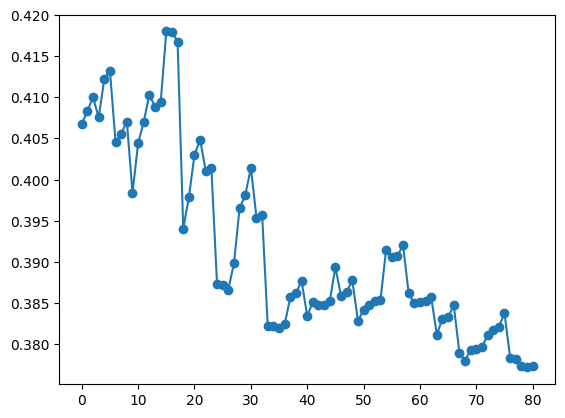

In [60]:
plt.plot(results_df2['pred_Q'])
plt.scatter(results_df2['pred_Q'].index,results_df2['pred_Q'])

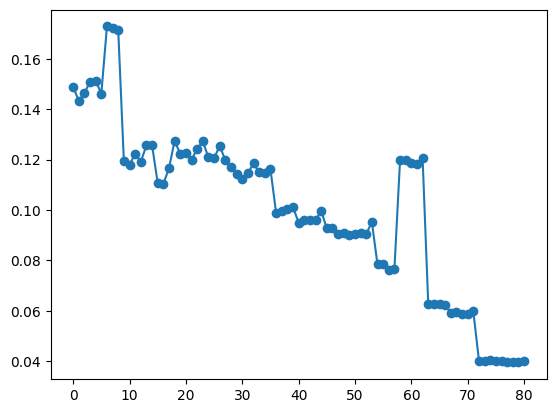

In [54]:
plt.plot(results_df1['pred_Q'])
plt.scatter(results_df1['pred_Q'].index,results_df1['pred_Q'])

In [51]:
results_df1

,I,J,coeff_new,R2_score,max_error,mae,pred_Q,pred_Qmax
0,0,0,"[{'A0('11-25')': 1.8991128187257627, 'A0('9-16...",0.799038,42.352930,13.185064,0.148705,0.872360
1,0,1,"[{'A0('11-25')': 1.8991128187257627, 'A0('9-16...",0.808669,41.876260,12.626000,0.143395,0.872360
2,0,2,"[{'A0('11-25')': 1.8991128187257627, 'A0('9-16...",0.813488,41.876260,12.529353,0.146355,0.872360
3,0,3,"[{'A0('11-25')': 1.8991128187257627, 'A0('9-16...",0.814365,41.254843,12.846144,0.150884,0.872360
4,0,4,"[{'A0('11-25')': 1.8991128187257627, 'A0('9-16...",0.810883,41.254843,13.337997,0.151234,0.872360
...,...,...,...,...,...,...,...,...
76,8,4,"[{'A0('11-25')': 2.117104834169361, 'A0('9-16'...",0.983623,12.057661,4.022771,0.040105,0.119243
77,8,5,"[{'A0('11-25')': 2.117104834169361, 'A0('9-16'...",0.983701,12.057661,3.997497,0.039845,0.119243
78,8,6,"[{'A0('11-25')': 2.138211082639285, 'A0('9-16'...",0.983902,11.927712,3.972847,0.039685,0.116467
79,8,7,"[{'A0('11-25')': 2.138211082639285, 'A0('9-16'...",0.983954,11.927712,3.954534,0.039493,0.116467


In [ ]:
right_bound[0, :]

array([   5,   10,    8,   23,   22,   90,  293,  395,  993,    4,   14,
          7,   10,   16,   56,  288,  382,  926,   29,   24,    8,   12,
         18,   80,  233,  355, 1070,   34,   38,   77,   57,   93,   76,
        126,  154,  199,  348,   26,   32,   47,   47,   73,   72,  149,
        121,  181,  204,   34,   40,   47,   48,   73,   70,  145,  146,
        176,  300])

In [ ]:
left_bound[0, :]

array([  0,   3,   1,   5,   4,  15, 100, 113,  76,   0,   4,   5,   5,
         3,   9,  98,  45,  90,   2,   4,   0,   5,   3,   5,  89,  91,
        83,  17,  18,  15,  23,  28,  31,  49,  26,  61,  59,  17,  19,
        12,  22,  29,  31,  49,  48,  86, 133,  16,  17,  17,  21,  23,
        32,  56,  19,  51,  45])

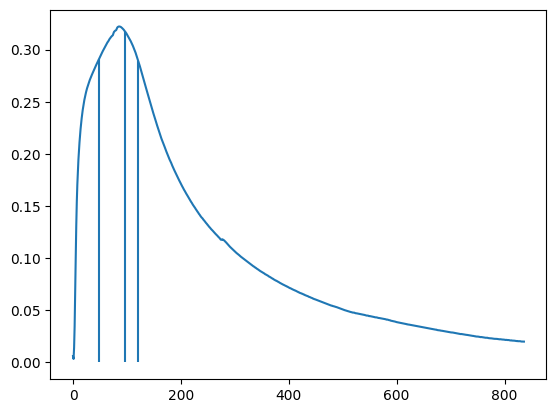

In [ ]:
plt.plot(B.iloc[:, 44])
plt.vlines(idp[44], 0, B.iloc[idp[44], 44])
plt.vlines(int(left_bound[0, 44]), 0, B.iloc[int(left_bound[0, 44]), 44])
plt.vlines(int(right_bound[0, 44]), 0, B.iloc[int(right_bound[0, 44]), 44])

In [ ]:
[B.iloc[maxes[i]:, i][B.iloc[maxes[i]:, i] >= np.array(B.iloc[maxes[i]:, i].max()*0.5)].iloc[-1] for i in range(57)]

[0.0372,
 0.0831,
 0.03,
 0.0332,
 0.0584,
 0.0495,
 0.0165,
 0.0302,
 0.0209,
 0.0764,
 0.0759,
 0.0361,
 0.0458,
 0.0712,
 0.0594,
 0.0159,
 0.0279,
 0.02,
 0.0342,
 0.0679,
 0.0316,
 0.0454,
 0.0649,
 0.0532,
 0.0172,
 0.0247,
 0.02,
 0.0347,
 0.0379,
 0.0567,
 0.0651,
 0.0785,
 0.0525,
 0.0488,
 0.0969,
 0.0629,
 0.0855,
 0.0445,
 0.0636,
 0.0955,
 0.102,
 0.1446,
 0.0637,
 0.0454,
 0.1618,
 0.0767,
 0.1705,
 0.0281,
 0.0341,
 0.0689,
 0.0612,
 0.079,
 0.052,
 0.0413,
 0.0708,
 0.0643,
 0.0787]